In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import clip
import meerkat as mk
import torch
from domino.clip import *

## Embed words

In [3]:
#words_dp = get_wiki_words(eng_only=True).load()
words_dp = get_wiki_words.out(run_id=4507).load()

task: get_wiki_words, run_id=4507


[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [37]:
#words_dp = embed_words(words_dp).load()
words_dp = embed_words.out(4508).load()

## Embed Images

In [2]:
from meerkat.contrib.visual_genome import read_visual_genome_dps
dataset_dir = "/home/common/datasets/visual-genome"
dps = read_visual_genome_dps(dataset_dir)

In [3]:
image_dp = dps["images"]
attr_dp = dps["attributes"]
object_dp = dp = dps["images"].merge(dps["objects"], on="image_id")

In [4]:
person_dp = object_dp.lz[object_dp["syn_name"].isin(["man.n.01", "person.n.01", "woman.n.01"])]

In [5]:
skiers = attr_dp.lz[attr_dp["attribute"] == "skiing"].merge(object_dp, on="object_id")

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [9]:
def crop_object(row):
    img = row["image"]
    
    length = max(row["h"], row["w"])
    box = (
        max(row["x"] - ((length - row["w"]) / 2), 0), 
        max(row["y"] - ((length - row["h"])  / 2), 0),
        min(row["x"] + row["w"] + ((length - row["w"]) / 2), img.width), 
        min(row["y"] + row["h"] + ((length - row["h"]) / 2), img.height)
    )
    return img.crop(box)

person_dp["person_img"] = person_dp.to_lambda(crop_object)

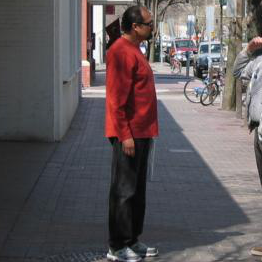

In [151]:
person_dp.lz[0]["person_img"].get()

In [10]:
from domino.clip import embed_images

In [11]:
person_dp = embed_images(dp=person_dp, img_column="person_img")

In [135]:
person_dp["has_attribute"] = np.isin(
    person_dp["object_id"], 
    attr_dp.lz[attr_dp["attribute"] == "reading"]["object_id"]
).astype(int)

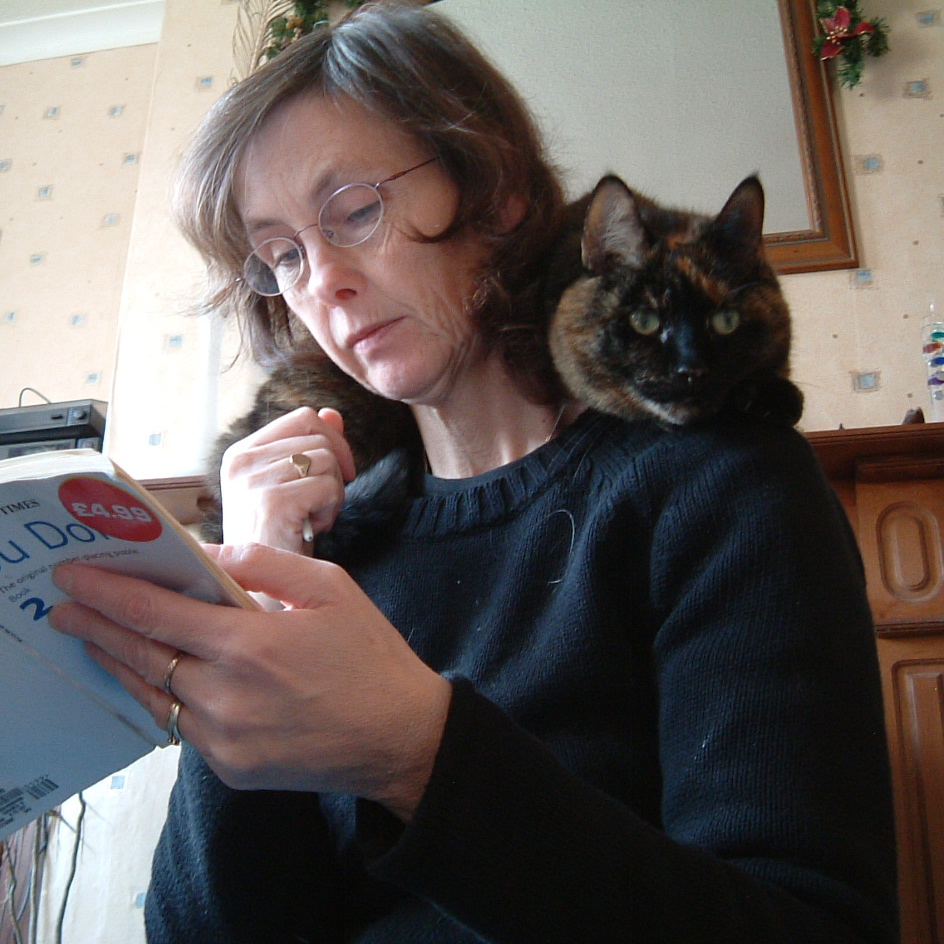

In [136]:
person_dp.lz[person_dp["has_attribute"] == 1][2]["person_img"]

In [137]:
attribute_scores = np.dot( 
    words_dp["emb"].data.numpy(),
    person_dp.lz[person_dp["has_attribute"] == 1]["emb"].data.numpy().mean(axis=0)
)
reference_scores = np.dot( 
    words_dp["emb"].data.numpy(),
    person_dp["emb"].data.numpy().mean(axis=0)
)
scores = attribute_scores - reference_scores

In [162]:
words_dp.lz[(-scores).argsort()[:20]]

,word (PandasSeriesColumn),frequency (PandasSeriesColumn),index (PandasSeriesColumn),tokens (LambdaColumn),emb (TensorColumn)
0,reading,139695,1618,LambdaCell(fn=<lambda>),torch.Tensor(shape=torch.Size([512]))
1,reading,139695,1617,LambdaCell(fn=<lambda>),torch.Tensor(shape=torch.Size([512]))
2,bibliotherapy,98,45634,LambdaCell(fn=<lambda>),torch.Tensor(shape=torch.Size([512]))
3,reader,33679,4200,LambdaCell(fn=<lambda>),torch.Tensor(shape=torch.Size([512]))
4,bibliophile,756,24701,LambdaCell(fn=<lambda>),torch.Tensor(shape=torch.Size([512]))
5,writing,315354,764,LambdaCell(fn=<lambda>),torch.Tensor(shape=torch.Size([512]))
6,writing,315354,763,LambdaCell(fn=<lambda>),torch.Tensor(shape=torch.Size([512]))
7,readership,5518,10823,LambdaCell(fn=<lambda>),torch.Tensor(shape=torch.Size([512]))
8,literacy,47306,3414,LambdaCell(fn=<lambda>),torch.Tensor(shape=torch.Size([512]))
9,bibliophilic,57,52172,LambdaCell(fn=<lambda>),torch.Tensor(shape=torch.Size([512]))
